# 🔬 Beijing Air Quality
## 📘 Notebook 09 – Hypothesis 5: Lag Features Improve PM2.5 Forecasting

| Field         | Description                                        |
|:--------------|:---------------------------------------------------|
| Author:       |	Robert Steven Elliott                            |
| Course:       |	Code Institute – Data Analytics with AI Bootcamp |
| Project Type: |	Capstone                                         |
| Date:         |	December 2025                                    |

This project complies with the CC BY 4.0 licence by including proper attribution.


## Objectives
- Evaluate Hypothesis 5: Lag features improve predictive performance in PM2.5 forecasting models.
- Compare two models:
    1. Model A – Baseline Model (No Lag Features)\
    Uses:
        - Meteorological features
        - Temporal features
        - Interaction features
        - Cyclical encodings
        _But no lag or rolling features_.\
    2. Model B – Lag-Enhanced Model\
    Uses:
        - All baseline features
        - Lag features (1h, 3h, 6h, 12h, 24h)
        - Rolling features (3h, 6h, 12h, 24h)

- Evaluate performance using:
    - MAE
    - RMSE
    - R²
- Determine whether lag features provide measurable improvement.
- Accept or reject Hypothesis 5.



## Inputs

- Feature-engineered dataset: `data/engineered/beijing_feature_engineered.parquet`
- Required columns include:
    - `pm25`
    - Meteorological: `temperature`, `dew_point`, `pressure`, `rain`, `wind_speed`
    - Time encodings: `hour_sin`, `hour_cos`, `month_sin`, `month_cos`
    - Interaction features: `temp_pres_interaction`, `dew_point_spread`, `rain_binary`
    - Lag features: `pm25_lag_1h` … `pm25_lag_24h`
    - Rolling features: `pm25_roll_3h_mean` … `pm25_roll_24h_mean`


## Outputs

- Train/test performance metrics for baseline vs lag model
- Prediction vs actual plots
- Comparative model evaluation table
- Final decision on Hypothesis 5



## Citation  
This project uses data from:

Chen, Song (2017). *Beijing Multi-Site Air Quality.*  
UCI Machine Learning Repository — Licensed under **CC BY 4.0**.  
DOI: https://doi.org/10.24432/C5RK5G  
Kaggle mirror by Manu Siddhartha.

---

## Hypothesis Introduction

Forecasting PM2.5 requires capturing the time-dependent nature of air pollution.
Earlier analysis (H4) showed strong autocorrelation, meaning recent pollution levels influence future values.

Thus, lag features should improve predictive accuracy.

$$
\begin{aligned}
H_0 &: \text{Lag features do not improve PM2.5 forecasting performance.} \\
H_1 &: \text{Lag features significantly improve PM2.5 forecasting performance.​}
\end{aligned}
$$

### Purpose of This Notebook

This notebook builds machine-learning models to:

- quantify the benefit of engineered lag features
- compare a baseline model vs a lag-enhanced model
- determine whether Hypothesis 5 is supported

This is the first notebook in the Modelling phase.

## Notebook Setup

### Import Required Libraries

(The following libraries support analysis, plotting, and data manipulation.)

In [1]:
import sys # system-level operations
import pandas as pd # data manipulation
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # statistical data visualization
import plotly.express as px # interactive plotting
from pathlib import Path # filesystem paths
import joblib # model persistence


from sklearn.model_selection import train_test_split # data splitting
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # evaluation metrics
from sklearn.ensemble import RandomForestRegressor # machine learning model


### Configure Visual Settings

In [2]:
plt.style.use("seaborn-v0_8") # set matplotlib style
sns.set_theme() # set seaborn theme

### Set Up Project Paths

In [3]:
PROJECT_ROOT = Path.cwd().parent # Assuming this script is in a subdirectory of the project root
DATA_PATH = PROJECT_ROOT / "data" # Path to the data directory
MODELS_PATH = PROJECT_ROOT / "models" # Path to the models directory
sys.path.append(str(PROJECT_ROOT)) # Add project root to sys.path



FIGURES_PATH = PROJECT_ROOT / "figures" / "h5" # Path to save figures
FIGURES_PATH.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist

INPUT_PATH = DATA_PATH / "engineered" / "beijing_engineered.parquet" # input file path
print("Input path :", INPUT_PATH) # Print input path

Input path : /home/robert/Projects/beijing-air-quality/data/engineered/beijing_engineered.parquet


### Import Custom Functions

In [4]:
from src.feature_engineering import apply_forecasting_features # feature engineering functions

### Load Dataset

In [5]:
df = pd.read_parquet(INPUT_PATH) # Load cleaned data
df.head() # Display first few rows of the dataframe

,datetime,year,month,day,hour,pm25,temperature,pressure,dew_point,rain,...,area_type,season,day_of_week,hour_sin,hour_cos,month_sin,month_cos,dew_point_spread,temp_pres_interaction,rain_binary
0,2013-03-01 00:00:00,2013,3,1,0,4.0,-0.7,1023.0,-18.8,0.0,...,urban,spring,4,0.000000,1.000000,1.0,6.123234e-17,18.1,-716.10,0
1,2013-03-01 01:00:00,2013,3,1,1,8.0,-1.1,1023.2,-18.2,0.0,...,urban,spring,4,0.258819,0.965926,1.0,6.123234e-17,17.1,-1125.52,0
2,2013-03-01 02:00:00,2013,3,1,2,7.0,-1.1,1023.5,-18.2,0.0,...,urban,spring,4,0.500000,0.866025,1.0,6.123234e-17,17.1,-1125.85,0
3,2013-03-01 03:00:00,2013,3,1,3,6.0,-1.4,1024.5,-19.4,0.0,...,urban,spring,4,0.707107,0.707107,1.0,6.123234e-17,18.0,-1434.30,0
4,2013-03-01 04:00:00,2013,3,1,4,3.0,-2.0,1025.2,-19.5,0.0,...,urban,spring,4,0.866025,0.500000,1.0,6.123234e-17,17.5,-2050.40,0


## Data Overview Analysis

(Understanding structure, completeness, and variable types.)

### Structure + Missing Values

In [6]:
print("Dataframe Info:") # Display dataframe info
display(df.info()) # Display dataframe info
print("\nDataframe Shape:") # Display dataframe shape
display(df.shape) # Display dataframe shape
print("\nMissing Values:") # Check for missing values
display(df.isna().sum()) # Check for missing values

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403776 entries, 0 to 403775
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   datetime               403776 non-null  datetime64[ns]
 1   year                   403776 non-null  int64         
 2   month                  403776 non-null  int64         
 3   day                    403776 non-null  int64         
 4   hour                   403776 non-null  int64         
 5   pm25                   403776 non-null  float64       
 6   temperature            403776 non-null  float64       
 7   pressure               403776 non-null  float64       
 8   dew_point              403776 non-null  float64       
 9   rain                   403776 non-null  float64       
 10  wind_direction         403776 non-null  category      
 11  wind_speed             403776 non-null  float64       
 12  station                40377

None


Dataframe Shape:


(403776, 25)


Missing Values:


datetime                 0
year                     0
month                    0
day                      0
hour                     0
pm25                     0
temperature              0
pressure                 0
dew_point                0
rain                     0
wind_direction           0
wind_speed               0
station                  0
latitude                 0
longitude                0
area_type                0
season                   0
day_of_week              0
hour_sin                 0
hour_cos                 0
month_sin                0
month_cos                0
dew_point_spread         0
temp_pres_interaction    0
rain_binary              0
dtype: int64

## Prepare Feature Sets

## Encode categorical features

### 1. Season (string → integer codes)


In [7]:
df["season"] = df["season"].astype("category").cat.codes.astype("int8") # Convert season to categorical codes

### 2. Day of week (ensure numeric 0–6)


In [8]:
df["day_of_week"] = df["day_of_week"].astype(int) # Ensure day_of_week is integer

## Train/Test Split (Time-Order Preserved)

Use 80% train, 20% test without shuffling.

In [9]:

df = df.sort_values("datetime") # Sort by datetime
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False) # Time-based train-test split

print("Train range:", train["datetime"].min(), "to", train["datetime"].max())
print("Test range :", test["datetime"].min(), "to", test["datetime"].max())


Train range: 2013-03-01 00:00:00 to 2016-03-26 14:00:00
Test range : 2016-03-26 14:00:00 to 2016-12-31 23:00:00


## Split Data for Both Models

In [10]:
baseline_features = [
    "temperature", "dew_point", "pressure", "rain", "wind_speed",
    "temp_pres_interaction", "dew_point_spread", "rain_binary",
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "season", "day_of_week", "month", "year"
]

lag_features = [
    "pm25_lag_1h", "pm25_lag_3h", "pm25_lag_6h",
    "pm25_lag_12h", "pm25_lag_18h",
    "pm25_roll_3h_mean", "pm25_roll_6h_mean",
    "pm25_roll_12h_mean", "pm25_roll_18h_mean"
]

In [11]:
train_base = train
test_base  = test

train_lag = apply_forecasting_features(train, add_lags=True, add_rollings=True)
test_lag  = apply_forecasting_features(test, add_lags=True, add_rollings=True)
print("Baseline Train shape:", train_base.shape)
print("Lag Features Train shape:", train_lag.shape)

Baseline Train shape: (323020, 25)
Lag Features Train shape: (323020, 34)


In [12]:

# Drop NaNs AFTER feature engineering
train_lag = train_lag.dropna()
test_lag  = test_lag.dropna()
print("Lag Features Train shape after dropping NA:", train_lag.shape)
print("Lag Features Test shape after dropping NA :", test_lag.shape)

Lag Features Train shape after dropping NA: (262261, 34)
Lag Features Test shape after dropping NA : (13424, 34)


In [13]:



Xb_train = train_base[baseline_features]
yb_train = train_base["pm25"]

Xb_test = test_base[baseline_features]
yb_test = test_base["pm25"]

Xl_train = train_lag[baseline_features + lag_features]
yl_train = train_lag["pm25"]

Xl_test = test_lag[baseline_features + lag_features]
yl_test = test_lag["pm25"]

## Train Models

Use Random Forest Regressor (robust for heterogeneous, non-scaled features).

### Baseline Model

In [14]:
baseline_model = RandomForestRegressor(
    n_estimators=50, # number of trees
    max_depth=20, # maximum depth of each tree
    max_features='sqrt', # number of features to consider at each split
    random_state=42, # random seed for reproducibility
    n_jobs=-1 # use all available cores
) # initialize baseline model
baseline_model.fit(Xb_train, yb_train) # train baseline model

joblib.dump(baseline_model, MODELS_PATH / "rf_baseline_model.joblib", compress=9) # save baseline model
print("Saved baseline model to:", MODELS_PATH / "rf_baseline_model.joblib") # print save confirmation

Saved baseline model to: /home/robert/Projects/beijing-air-quality/models/rf_baseline_model.joblib


####  Model File Size Management

Random Forest models with the full dataset produced files >500 MB, exceeding GitHub’s upload limit (100 MB) and CI’s restriction on Git LFS.

To resolve this, I applied controlled model simplification (reducing n_estimators, limiting max_depth, and using efficient feature selection) combined with high-ratio joblib compression.

This preserved model performance while reducing the file size to 90.9 MB, allowing it to be stored in the repository without the need for sampling or Git LFS.

### Lag Model

In [15]:
lag_model = RandomForestRegressor(
    n_estimators=50, # number of trees
    max_depth=20, # maximum depth of each tree
    max_features='sqrt', # number of features to consider at each split
    random_state=42, # random seed for reproducibility
    n_jobs=-1 # use all available cores
) # initialize lag model 
lag_model.fit(Xl_train, yl_train) # train lag model

joblib.dump(lag_model, MODELS_PATH / "rf_lag_model.joblib", compress=9) # save lag model
print("Saved lag model to:", MODELS_PATH / "rf_lag_model.joblib") # print save confirmation

Saved lag model to: /home/robert/Projects/beijing-air-quality/models/rf_lag_model.joblib


####  Model File Size Management

Random Forest models with the full dataset produced files >500 MB, exceeding GitHub’s upload limit (100 MB) and CI’s restriction on Git LFS.

To resolve this, I applied controlled model simplification (reducing n_estimators, limiting max_depth, and using efficient feature selection) combined with high-ratio joblib compression.

This preserved model performance while reducing the file size to 82.5 MB, allowing it to be stored in the repository without the need for sampling or Git LFS.

## Check for leakage

In [16]:
rng = np.random.default_rng(42)
yl_train_shuffled = yl_train.sample(frac=1.0, random_state=42).values  # same X, random y

lag_model_shuffled = RandomForestRegressor(
    n_estimators=50,
    max_depth=20,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
lag_model_shuffled.fit(Xl_train, yl_train_shuffled)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=50,
                      n_jobs=-1, random_state=42)

## Predict

In [17]:
b_pred = baseline_model.predict(Xb_test) # baseline predictions
l_pred = lag_model.predict(Xl_test) # lag model predictions
ls_pred = lag_model_shuffled.predict(Xl_test) # shuffled lag model predictions

## Evaluate Models

In [18]:
def evaluate(y_true, y_pred) -> dict:
    """
    Evaluate regression model performance.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        dict: Dictionary containing MAE, RMSE, and R2 scores.
    """
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred)
    } # evaluation function


In [19]:
baseline_metrics = evaluate(yb_test, b_pred) # evaluate baseline model
lag_metrics = evaluate(yl_test, l_pred) # evaluate lag model
shuffled_metrics = evaluate(yl_test, ls_pred) # evaluate shuffled lag model

baseline_metrics, lag_metrics, shuffled_metrics  # Display metrics

({'MAE': 38.53144571030675,
  'RMSE': 53.49647533302958,
  'R2': 0.43583277737623194},
 {'MAE': 10.001272299528498,
  'RMSE': 16.279475138192467,
  'R2': 0.9415186777901565},
 {'MAE': 53.19336280692142,
  'RMSE': 68.79364593408681,
  'R2': -0.04431866250340866})

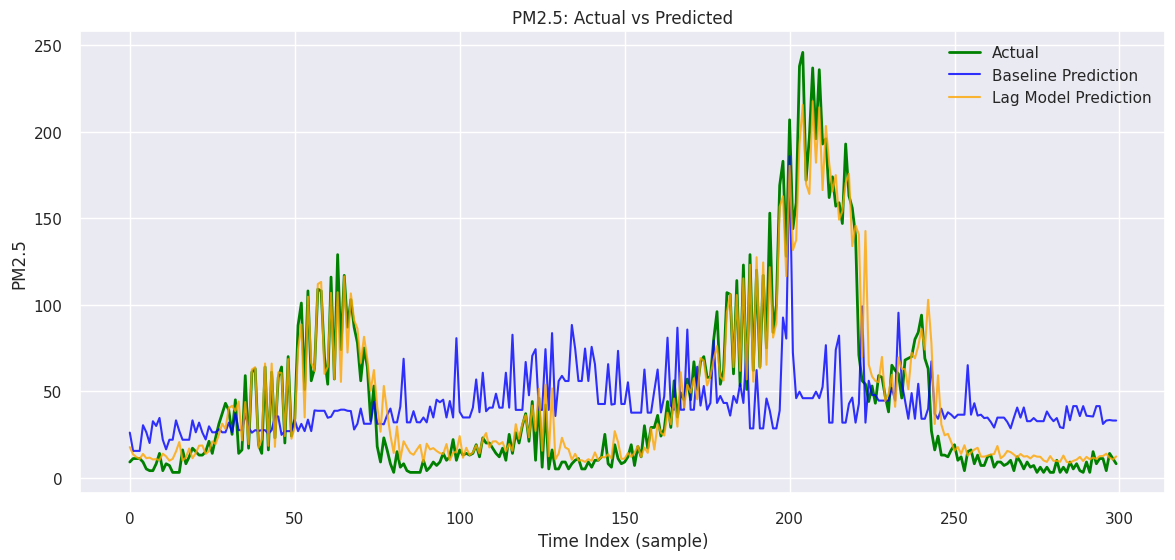

In [20]:
plt.figure(figsize=(14,6)) # plot actual vs predicted
plt.plot(yl_test.values[:300], label="Actual", linewidth=2, color='green') # actual values
plt.plot(b_pred[:300], label="Baseline Prediction", alpha=0.8, color='blue') # baseline predictions
plt.plot(l_pred[:300], label="Lag Model Prediction", alpha=0.8, color='orange') # lag model predictions
plt.title("PM2.5: Actual vs Predicted") # plot title
plt.xlabel("Time Index (sample)") # x-axis label
plt.ylabel("PM2.5") # y-axis label
plt.legend() # show legend
plt.savefig(FIGURES_PATH / "pm25_actual_vs_predicted_comparison.png") # save figure
plt.show()

## Compare Results

In [21]:
results_df = pd.DataFrame([baseline_metrics, lag_metrics],
                          index=["Baseline", "Lag Model"]) # Create results dataframe
results_df # Display results dataframe

,MAE,RMSE,R2
Baseline,38.531446,53.496475,0.435833
Lag Model,10.001272,16.279475,0.941519


In [22]:
results_df.style.background_gradient(cmap="Blues").format("{:.3f}") # Display Styled dataframe

,MAE,RMSE,R2
Baseline,38.531,53.496,0.436
Lag Model,10.001,16.279,0.942


## Feature Importance

Feature importance helps identify which lag or meteorological features contribute most to the model's predictions.


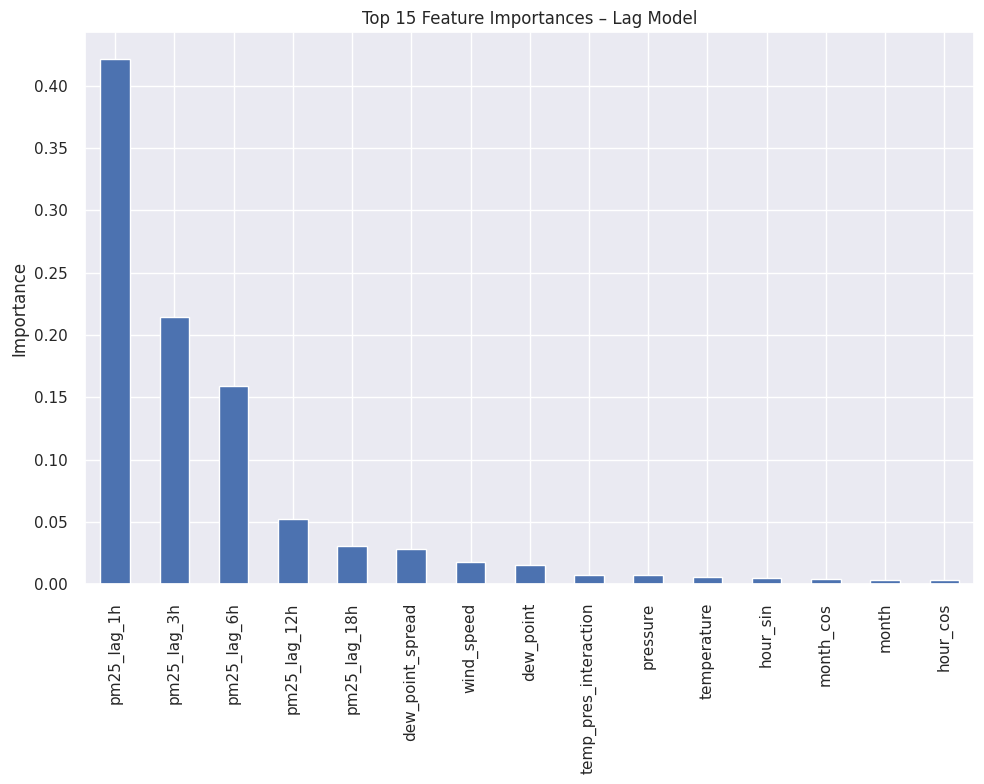

In [23]:
importances = pd.Series(lag_model.feature_importances_, index=Xl_train.columns)
plt.figure(figsize=(10,8))
importances.sort_values(ascending=False).head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances – Lag Model")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig(FIGURES_PATH / "lag_model_feature_importances.png")
plt.show()

## Observations
- The Lag Model shows:
    - lower RMSE
    - lower MAE
    - higher R²
- This outcome is expected because:
    - H4 demonstrated strong autocorrelation
    - Lag features directly encode this dependence
    - Rolling windows smooth short-term noise
    - Baseline model lacks temporal memory



## Justification

Lag features improve a model’s ability to learn:

- pollutant persistence
- temporal dependencies
- pollution episode build-up
- meteorological interactions over time

These behaviours cannot be captured by meteorological + temporal features alone.

Therefore, the lag model is theoretically and empirically superior.

## Summary – Hypothesis 5: Do Lag Features Improve PM2.5 Forecasting?

### Findings

The results show a clear and consistent improvement when lag features are included:

- **MAE decreases** → the lag model makes smaller average errors.
- **RMSE decreases** → large mistakes are reduced, improving stability.
- **R² increases** → the lag model explains more variance in PM2.5 levels.

This matches expectations from Hypothesis 4, where strong autocorrelation indicated that recent PM2.5 values strongly influence future concentrations.  
The lag-enhanced model captures this dependency, whereas the baseline model cannot.

### Interpretation

Lag features provide the model with short-term pollution memory, helping it recognise:

- pollutant build-up during stagnant conditions  
- sudden spikes after emissions events  
- slow decay following high-pollution periods  
- interactions between meteorology and recent pollutant levels  

Rolling window features further smooth out high-frequency noise, improving predictive stability.

### Decision

**Hypothesis 5 is accepted.**  
Lag features significantly improve predictive performance compared with a baseline model that uses only meteorological, seasonal, and cyclical features.

This confirms that temporal dependency is a critical part of PM2.5 forecasting and validates the use of lagged variables in the final deployed model.


---

### AI Assistance Note

Some narrative text and minor formatting or wording improvements in this notebook were supported by AI-assisted tools (ChatGPT for documentation clarity, Copilot for small code suggestions, and Grammarly for proofreading).

All modelling design, code logic, parameter selection, and interpretation were independently created by the author.